# Setup

Upgrade scikit-learn

In [1]:
%%capture
!pip install --upgrade scikit-learn

Import libraries

In [2]:
import gc
gc.enable()

import warnings
warnings.filterwarnings(category=FutureWarning, action='ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
from sklearn.metrics import (
    roc_auc_score, 
    matthews_corrcoef,
    classification_report
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, TargetEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    ExtraTreesClassifier, 
    RandomForestClassifier,
    AdaBoostClassifier
)
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

SEED = 2024

Import dataset

In [3]:
data = pd.read_csv('/kaggle/input/hotel-booking-demand/hotel_bookings.csv')

# Data overview

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

To estimate demand for rooms, we will predict whether existing bookings will be canceled or not.  
**Target: *is_canceled***  

We will drop some columns from the dataset that leak information about the target, in order to simulate actual demand prediction.

In [5]:
leakage_cols = [
    'reservation_status', 
    'reservation_status_date', 
    'booking_changes',
    'deposit_type'
]

data = data.drop(leakage_cols, axis=1)

In [6]:
TARGET = 'is_canceled'
features = list(data.columns)
features.remove(TARGET)

**Duplicates**

In [7]:
data.duplicated().sum()

32959

In [8]:
data.duplicated(subset=features).sum()

33242

In [9]:
data.loc[data.duplicated(keep=False)].sort_values(by=features)[:6]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
40643,City Hotel,1,0,2015,August,32,4,0,1,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,A,A,NaN,NaN,0,Transient,0.0,0,0
40644,City Hotel,1,0,2015,August,32,4,0,1,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,A,A,NaN,NaN,0,Transient,0.0,0,0
40772,City Hotel,0,0,2015,August,32,7,0,2,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,A,A,14.0,NaN,0,Transient,75.0,0,1
40802,City Hotel,0,0,2015,August,32,7,0,2,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,A,A,14.0,NaN,0,Transient,75.0,0,1
40821,City Hotel,0,0,2015,August,32,8,0,1,2,0.0,0,SC,PRT,Online TA,TA/TO,0,0,0,A,A,9.0,NaN,0,Transient,89.0,0,1
40838,City Hotel,0,0,2015,August,32,8,0,1,2,0.0,0,SC,PRT,Online TA,TA/TO,0,0,0,A,A,9.0,NaN,0,Transient,89.0,0,1


In [10]:
# keeping only one out of each set of completely duplicate rows
data = data.drop_duplicates(keep='first')

In [11]:
data.loc[data.duplicated(subset=features, keep=False)].sort_values(by=features)[:6]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
41462,City Hotel,0,0,2015,August,34,17,1,0,1,0.0,0,BB,PRT,Direct,Direct,0,0,0,A,A,NaN,NaN,0,Transient,114.0,0,0
41466,City Hotel,1,0,2015,August,34,17,1,0,1,0.0,0,BB,PRT,Direct,Direct,0,0,0,A,A,NaN,NaN,0,Transient,114.0,0,0
61480,City Hotel,1,0,2016,December,51,14,0,1,1,0.0,0,SC,PRT,Complementary,Direct,0,0,0,A,A,NaN,NaN,0,Transient,0.0,0,0
103201,City Hotel,0,0,2016,December,51,14,0,1,1,0.0,0,SC,PRT,Complementary,Direct,0,0,0,A,A,NaN,NaN,0,Transient,0.0,0,0
47523,City Hotel,1,0,2016,February,9,26,0,1,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,A,A,NaN,NaN,0,Transient,89.0,0,0
84501,City Hotel,0,0,2016,February,9,26,0,1,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,A,A,NaN,NaN,0,Transient,89.0,0,0


In [12]:
# drop all rows where features are the same but target value is contradictory
data = data.drop_duplicates(keep=False, ignore_index=True)

In [13]:
data.shape

(86431, 28)

**Class ratio**

In [14]:
data[TARGET].value_counts(normalize=True)

is_canceled
0    0.726325
1    0.273675
Name: proportion, dtype: float64

Imbalanced, but no resampling is required. Cost-sensitive learning and threshold-tuning are enough to handle the imbalance.

In [15]:
class_ratio = data[TARGET].value_counts()[0] / data[TARGET].value_counts()[1]
class_ratio = round(class_ratio, 2)
class_ratio

2.65

**Data summary**

In [16]:
cat_features = list(data.select_dtypes('object').columns)
cat_features.extend(['arrival_date_year', 'is_repeated_guest', 'agent', 'company'])

num_features = [f for f in features if f not in cat_features]

In [17]:
data[num_features].describe()

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,86431.000000,86431.000000,86431.000000,86431.00000,86431.000000,86431.000000,86427.000000,86431.000000,86431.000000,86431.000000,86431.000000,86431.000000,86431.000000,86431.000000
mean,79.279691,26.819405,15.808761,1.00634,2.625979,1.877278,0.139736,0.010922,0.030313,0.185859,0.694033,106.526445,0.084970,0.701808
std,85.520593,13.668228,8.836680,1.03216,2.054352,0.627269,0.457575,0.114124,0.370599,1.741186,9.494829,55.133268,0.282671,0.832395
min,0.000000,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,11.000000,16.000000,8.000000,0.00000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,72.245000,0.000000,0.000000
50%,49.000000,27.000000,16.000000,1.00000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,98.400000,0.000000,1.000000
75%,124.000000,37.000000,23.000000,2.00000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,134.165000,0.000000,1.000000
max,737.000000,53.000000,31.000000,19.00000,50.000000,55.000000,10.000000,10.000000,26.000000,72.000000,391.000000,5400.000000,8.000000,5.000000


In [18]:
data[cat_features].astype('category').describe()

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,customer_type,arrival_date_year,is_repeated_guest,agent,company
count,86431,86431,86431,85980,86431,86431,86431,86431,86431,86431,86431,74444.0,5155.0
unique,2,12,5,177,8,5,10,12,4,3,2,333.0,352.0
top,City Hotel,August,BB,PRT,Online TA,TA/TO,A,A,Transient,2016,0,9.0,40.0
freq,52836,11185,67283,27056,51329,68389,55754,45644,71631,41936,83026,28588.0,848.0


# Feature exploration + engineering

In [19]:
def cat_dist(f):    
    print('Category proportions:\n', data[f].value_counts(normalize=True, dropna=False))
    print('\nTarget splits for each category:\n', data.groupby(f, dropna=False)[TARGET].value_counts(normalize=True))

In [20]:
def num_dist(f, clip=None):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
    plt.suptitle(f'{f}')
    plt.minorticks_on()
    ax[0].set_title(f"Distribution split by target")
    sns.kdeplot(x=f, data=data, hue=TARGET, clip=clip, cut=0, ax=ax[0])
    ax[1].set_title(f"Distribution for positive class")
    sns.kdeplot(x=f, data=data.loc[data[TARGET]==1], clip=clip, cut=0, ax=ax[1])
    plt.tight_layout()
    plt.show()

### Categorical features

**hotel**

In [21]:
cat_dist('hotel')

Category proportions:
 hotel
City Hotel      0.611308
Resort Hotel    0.388692
Name: proportion, dtype: float64

Target splits for each category:
 hotel         is_canceled
City Hotel    0              0.700886
              1              0.299114
Resort Hotel  0              0.766334
              1              0.233666
Name: proportion, dtype: float64


City hotels have a higher cancellation rate.

**arrival_date_month**

In [22]:
cat_dist('arrival_date_month')

Category proportions:
 arrival_date_month
August       0.129410
July         0.115676
May          0.095406
April        0.090292
June         0.089031
March        0.086092
October      0.078930
September    0.075806
February     0.070067
December     0.058717
November     0.056901
January      0.053673
Name: proportion, dtype: float64

Target splits for each category:
 arrival_date_month  is_canceled
April               0              0.696438
                    1              0.303562
August              0              0.678945
                    1              0.321055
December            0              0.733399
                    1              0.266601
February            0              0.769155
                    1              0.230845
January             0              0.779909
                    1              0.220091
July                0              0.683237
                    1              0.316763
June                0              0.697336
                    1 

Winter months have fewer bookings but lower proportion of cancellations too.

In [23]:
winter = ('September', 'October', 'November', 'December', 'January', 'February', 'March')
data['arrival_month_bin'] = data.arrival_date_month.apply(lambda x: x in winter).astype('int')

In [24]:
cat_dist('arrival_month_bin')

Category proportions:
 arrival_month_bin
0    0.519813
1    0.480187
Name: proportion, dtype: float64

Target splits for each category:
 arrival_month_bin  is_canceled
0                  0              0.691796
                   1              0.308204
1                  0              0.763704
                   1              0.236296
Name: proportion, dtype: float64


**arrival_date_year**

In [25]:
cat_dist('arrival_date_year')

Category proportions:
 arrival_date_year
2016    0.485196
2017    0.363353
2015    0.151450
Name: proportion, dtype: float64

Target splits for each category:
 arrival_date_year  is_canceled
2015               0              0.798854
                   1              0.201146
2016               0              0.737123
                   1              0.262877
2017               0              0.681675
                   1              0.318325
Name: proportion, dtype: float64


Cancellations are increasing in proportion every year. We can treat this as a numerical feature.  
To change the scale, we can subtract the minimum year from each value.

In [26]:
data['arrival_date_year'] = data.arrival_date_year - 2015

In [27]:
cat_features.remove('arrival_date_year')
num_features.append('arrival_date_year')

**meal**

In [28]:
cat_dist('meal')

Category proportions:
 meal
BB           0.778459
SC           0.109139
HB           0.103134
Undefined    0.005241
FB           0.004026
Name: proportion, dtype: float64

Target splits for each category:
 meal       is_canceled
BB         0              0.735921
           1              0.264079
FB         0              0.735632
           1              0.264368
HB         0              0.730761
           1              0.269239
SC         0              0.647726
           1              0.352274
Undefined  0              0.843267
           1              0.156733
Name: proportion, dtype: float64


Some categories are extremely rare. Only ~11% shows a different target split.

In [29]:
data['meal_bin'] = (data.meal == 'SC').astype('int')

In [30]:
cat_dist('meal_bin')

Category proportions:
 meal_bin
0    0.890861
1    0.109139
Name: proportion, dtype: float64

Target splits for each category:
 meal_bin  is_canceled
0         0              0.735954
          1              0.264046
1         0              0.647726
          1              0.352274
Name: proportion, dtype: float64


**country**

In [31]:
data['country'].value_counts(normalize=True, dropna=False)[:10]

country
PRT    0.313036
GBR    0.119274
FRA    0.101387
ESP    0.083327
DEU    0.061679
ITA    0.034976
IRL    0.034421
BEL    0.023973
BRA    0.022932
NLD    0.022006
Name: proportion, dtype: float64

Most of the top countries are European.

In [32]:
data.country.nunique()

177

In [33]:
data.groupby('country', dropna=False)[TARGET].value_counts().sort_values(ascending=False)[:20]

country  is_canceled
PRT      0              17488
         1               9568
GBR      0               8349
FRA      0               7042
ESP      0               5358
DEU      0               4289
IRL      0               2322
ITA      0               1963
GBR      1               1960
ESP      1               1844
FRA      1               1721
BEL      0               1662
NLD      0               1555
USA      0               1406
BRA      0               1260
CHE      0               1180
ITA      1               1060
DEU      1               1042
CN       0                860
AUT      0                763
Name: count, dtype: int64

In [34]:
data.loc[data.country.isna()][TARGET].value_counts(normalize=True)

is_canceled
0    0.926829
1    0.073171
Name: proportion, dtype: float64

* Cancellation rate is much higher in Portugal, Italy & Spain, as compared to the other major countries.  
  We can create a binary feature as: 'Portugal + neighbours' vs 'Other foreign countries'
  
* Since it is a high cardinality categorical feature, we can apply target encoding in our pipeline for this feature.

In [35]:
def country_to_binary(country):
    if country in ('PRT', 'ITA', 'ESP'):
        return 1
    else:
        return 0
    
data['country_bin'] = data['country'].apply(country_to_binary)

In [36]:
cat_dist('country_bin')

Category proportions:
 country_bin
0    0.568662
1    0.431338
Name: proportion, dtype: float64

Target splits for each category:
 country_bin  is_canceled
0            0              0.772492
             1              0.227508
1            0              0.665460
             1              0.334540
Name: proportion, dtype: float64


**market_segment**

In [37]:
cat_dist('market_segment')

Category proportions:
 market_segment
Online TA        0.593873
Offline TA/TO    0.158080
Direct           0.135854
Groups           0.053372
Corporate        0.048131
Complementary    0.008076
Aviation         0.002592
Undefined        0.000023
Name: proportion, dtype: float64

Target splits for each category:
 market_segment  is_canceled
Aviation        0              0.803571
                1              0.196429
Complementary   0              0.875358
                1              0.124642
Corporate       0              0.880288
                1              0.119712
Direct          0              0.853688
                1              0.146312
Groups          0              0.731411
                1              0.268589
Offline TA/TO   0              0.853400
                1              0.146600
Online TA       0              0.648094
                1              0.351906
Undefined       1              1.000000
Name: proportion, dtype: float64


'Online TA' has a majority proportion and also the only one with a different target split.  
We can binarize this feature as: 'Online TA' vs rest

In [38]:
data['market_segment_bin'] = (data['market_segment'] == 'Online TA').astype('int')

In [39]:
cat_dist('market_segment_bin')

Category proportions:
 market_segment_bin
1    0.593873
0    0.406127
Name: proportion, dtype: float64

Target splits for each category:
 market_segment_bin  is_canceled
0                   0              0.840721
                    1              0.159279
1                   0              0.648094
                    1              0.351906
Name: proportion, dtype: float64


**distribution_channel**

In [40]:
cat_dist('distribution_channel')

Category proportions:
 distribution_channel
TA/TO        0.791255
Direct       0.149021
Corporate    0.057607
GDS          0.002059
Undefined    0.000058
Name: proportion, dtype: float64

Target splits for each category:
 distribution_channel  is_canceled
Corporate             0              0.873268
                      1              0.126732
Direct                0              0.852795
                      1              0.147205
GDS                   0              0.808989
                      1              0.191011
TA/TO                 0              0.691632
                      1              0.308368
Undefined             1              0.800000
                      0              0.200000
Name: proportion, dtype: float64


Only 'TA/TO' has a different distribution so we can binarize this feature accordingly.

In [41]:
data['distribution_channel_bin'] = (data['distribution_channel'] == 'TA/TO').astype('int')

In [42]:
cat_dist('distribution_channel_bin')

Category proportions:
 distribution_channel_bin
1    0.791255
0    0.208745
Name: proportion, dtype: float64

Target splits for each category:
 distribution_channel_bin  is_canceled
0                         0              0.857832
                          1              0.142168
1                         0              0.691632
                          1              0.308368
Name: proportion, dtype: float64


**reserved_room_type**

In [43]:
cat_dist('reserved_room_type')

Category proportions:
 reserved_room_type
A    0.645069
D    0.200067
E    0.069639
F    0.032604
G    0.023660
B    0.011373
C    0.010552
H    0.006896
L    0.000069
P    0.000069
Name: proportion, dtype: float64

Target splits for each category:
 reserved_room_type  is_canceled
A                   0              0.741669
                    1              0.258331
B                   0              0.681587
                    1              0.318413
C                   0              0.676535
                    1              0.323465
D                   0              0.700440
                    1              0.299560
E                   0              0.729025
                    1              0.270975
F                   0              0.698722
                    1              0.301278
G                   0              0.642054
                    1              0.357946
H                   0              0.592282
                    1              0.407718
L             

No significant difference in target splits between the major categories.

**assigned_room_type**

In [44]:
cat_dist('assigned_room_type')

Category proportions:
 assigned_room_type
A    0.528098
D    0.257385
E    0.082771
F    0.041860
G    0.028809
C    0.024852
B    0.020710
H    0.008157
I    0.004119
K    0.003159
P    0.000069
L    0.000012
Name: proportion, dtype: float64

Target splits for each category:
 assigned_room_type  is_canceled
A                   0              0.695360
                    1              0.304640
B                   0              0.781564
                    1              0.218436
C                   0              0.817039
                    1              0.182961
D                   0              0.758518
                    1              0.241482
E                   0              0.765166
                    1              0.234834
F                   0              0.753455
                    1              0.246545
G                   0              0.699598
                    1              0.300402
H                   0              0.646809
                    1         

Reserved rooms are not exactly the same as assigned rooms.  
We can check their association and its effect on the target.

In [45]:
data['same_room_assigned'] = (data['reserved_room_type'] == data['assigned_room_type']).astype('int')

In [46]:
cat_dist('same_room_assigned')

Category proportions:
 same_room_assigned
1    0.849915
0    0.150085
Name: proportion, dtype: float64

Target splits for each category:
 same_room_assigned  is_canceled
0                   0              0.952976
                    1              0.047024
1                   0              0.686301
                    1              0.313699
Name: proportion, dtype: float64


Surprisingly, cancellations are lower when reserved and assigned rooms are not the same. Maybe the changes were upgrades.

**customer_type**

In [47]:
cat_dist('customer_type')

Category proportions:
 customer_type
Transient          0.828765
Transient-Party    0.128889
Contract           0.036098
Group              0.006248
Name: proportion, dtype: float64

Target splits for each category:
 customer_type    is_canceled
Contract         0              0.836538
                 1              0.163462
Group            0              0.900000
                 1              0.100000
Transient        0              0.700200
                 1              0.299800
Transient-Party  0              0.855027
                 1              0.144973
Name: proportion, dtype: float64


Majority category 'Transient' has a different target split.  
We can binarize this feature as 'Transient' vs rest.

In [48]:
data['customer_type_bin'] = (data.customer_type == 'Transient').astype('int')

In [49]:
cat_dist('customer_type_bin')

Category proportions:
 customer_type_bin
1    0.828765
0    0.171235
Name: proportion, dtype: float64

Target splits for each category:
 customer_type_bin  is_canceled
0                  0              0.85277
                   1              0.14723
1                  0              0.70020
                   1              0.29980
Name: proportion, dtype: float64


**is_repeated_guest**

In [50]:
cat_dist('is_repeated_guest')

Category proportions:
 is_repeated_guest
0    0.960604
1    0.039396
Name: proportion, dtype: float64

Target splits for each category:
 is_repeated_guest  is_canceled
0                  0              0.718233
                   1              0.281767
1                  0              0.923642
                   1              0.076358
Name: proportion, dtype: float64


Extremely imbalanced feature -> low variance.  
Difference in target splits but need statistical tests to determine if it is significant (due to the imbalance).

**agent**

In [51]:
data.agent.nunique()

333

In [52]:
data.agent.unique()[:10]

array([ nan, 304., 240., 303.,  15., 241.,   8., 250., 115.,   5.])

In [53]:
data.agent.value_counts(dropna=False).head()

agent
9.0      28588
240.0    12945
NaN      11987
14.0      3340
7.0       3292
Name: count, dtype: int64

In [54]:
data.groupby('agent')[TARGET].value_counts(normalize=True, dropna=False)[:10]

agent  is_canceled
1.0    0              0.628425
       1              0.371575
2.0    0              0.896825
       1              0.103175
3.0    0              0.713043
       1              0.286957
4.0    1              0.533333
       0              0.466667
5.0    0              0.767442
       1              0.232558
Name: proportion, dtype: float64

Categorical feature with high cardinality -> target encoding will be suitable.

**company**

In [55]:
data.company.nunique()

352

In [56]:
data.company.unique()[:10]

array([ nan, 110., 113., 270., 178., 240., 154., 144., 307., 268.])

In [57]:
data.company.value_counts(dropna=False, normalize=True).head()

company
NaN      0.940357
40.0     0.009811
223.0    0.005357
45.0     0.002742
153.0    0.002372
Name: proportion, dtype: float64

Most of the values are missing. We will drop this feature instead of encoding it.

In [58]:
data = data.drop('company', axis=1)
features.remove('company')
cat_features.remove('company')

### Numerical features

**lead_time**

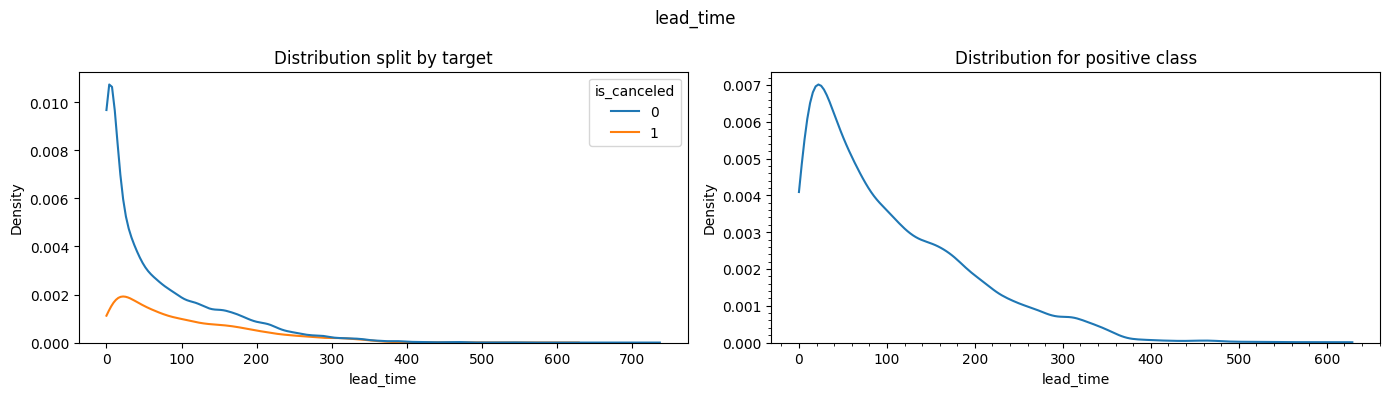

In [59]:
num_dist('lead_time')

In [60]:
data.loc[data.lead_time == 0][TARGET].value_counts(normalize=True)

is_canceled
0    0.940612
1    0.059388
Name: proportion, dtype: float64

In [61]:
data.loc[data.lead_time <= 10][TARGET].value_counts(normalize=True)

is_canceled
0    0.900776
1    0.099224
Name: proportion, dtype: float64

Lower lead time results in lower proportion of cancellations.

In [62]:
data.loc[data.lead_time >= 30][TARGET].value_counts(normalize=True)

is_canceled
0    0.653781
1    0.346219
Name: proportion, dtype: float64

In [63]:
data.loc[data.lead_time >= 200][TARGET].value_counts(normalize=True)

is_canceled
0    0.593427
1    0.406573
Name: proportion, dtype: float64

Higher lead time result in higher proportion of cancellations.  
We can keep this feature numerical instead of creating categorial features.

**arrival_data_week_number**

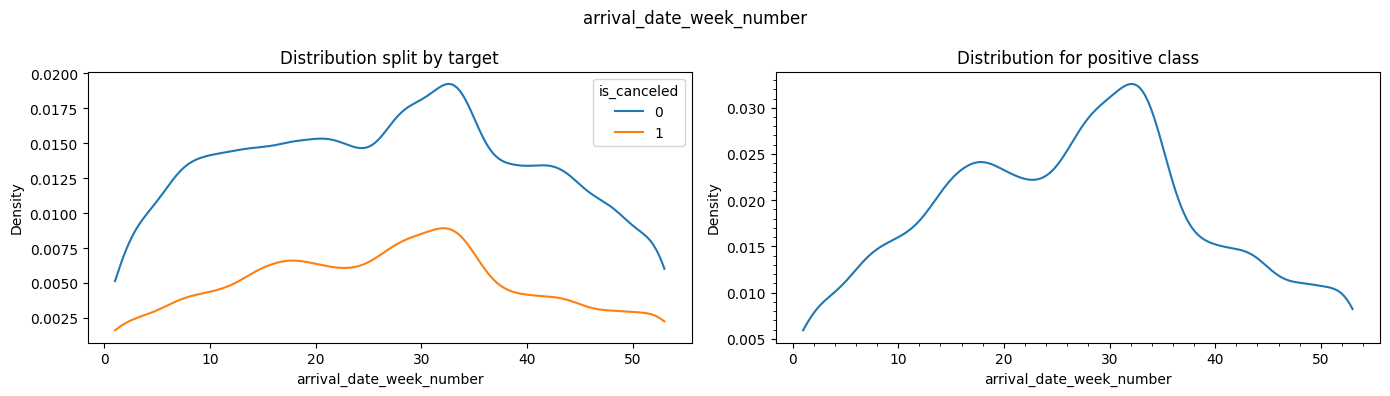

In [64]:
num_dist('arrival_date_week_number')

As expected, this distribution reflects the observations from the 'arrival_date_month'.  
We must check for redundancy between these two features before modeling.

**arrival_date_day_of_month**

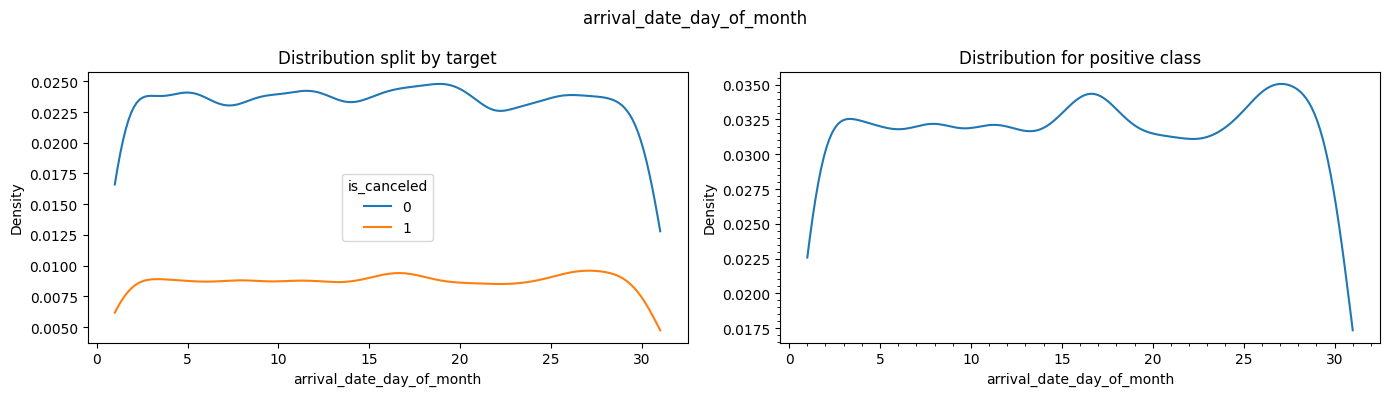

In [65]:
num_dist('arrival_date_day_of_month')

Uniform distribution with a slight peak in cancellations at the end of the month.  
Proportion of cancellations looks constant throughout.

**stays_in_weekend_nights**

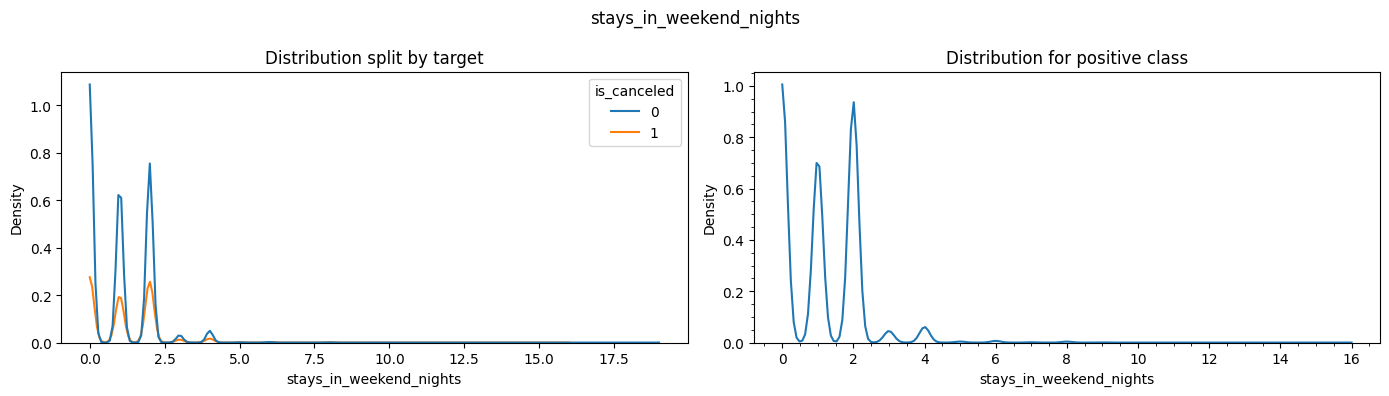

In [66]:
num_dist('stays_in_weekend_nights')

In [67]:
data.groupby('stays_in_weekend_nights')[TARGET].value_counts(normalize=True)[:12]

stays_in_weekend_nights  is_canceled
0                        0              0.754427
                         1              0.245573
1                        0              0.726704
                         1              0.273296
2                        0              0.695685
                         1              0.304315
3                        0              0.664042
                         1              0.335958
4                        0              0.699651
                         1              0.300349
5                        1              0.514706
                         0              0.485294
Name: proportion, dtype: float64

In [68]:
data['only_weekday_stay'] = (data['stays_in_weekend_nights'] == 0).astype('int')

In [69]:
cat_dist('only_weekday_stay')

Category proportions:
 only_weekday_stay
0    0.598165
1    0.401835
Name: proportion, dtype: float64

Target splits for each category:
 only_weekday_stay  is_canceled
0                  0              0.707447
                   1              0.292553
1                  0              0.754427
                   1              0.245573
Name: proportion, dtype: float64


**stays_in_week_nights**

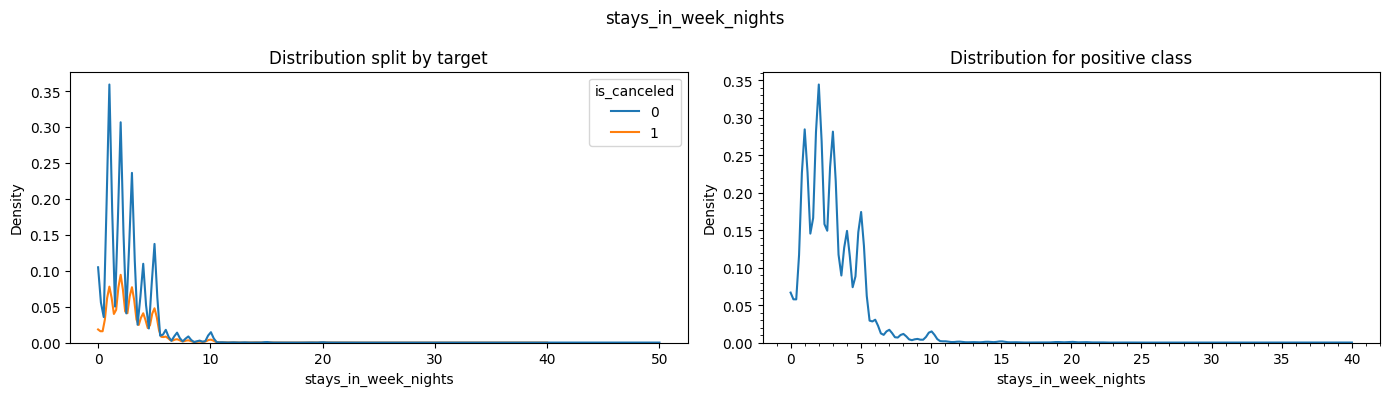

In [70]:
num_dist('stays_in_week_nights')

In [71]:
data['total_stay'] = data['stays_in_weekend_nights'] + data['stays_in_week_nights']

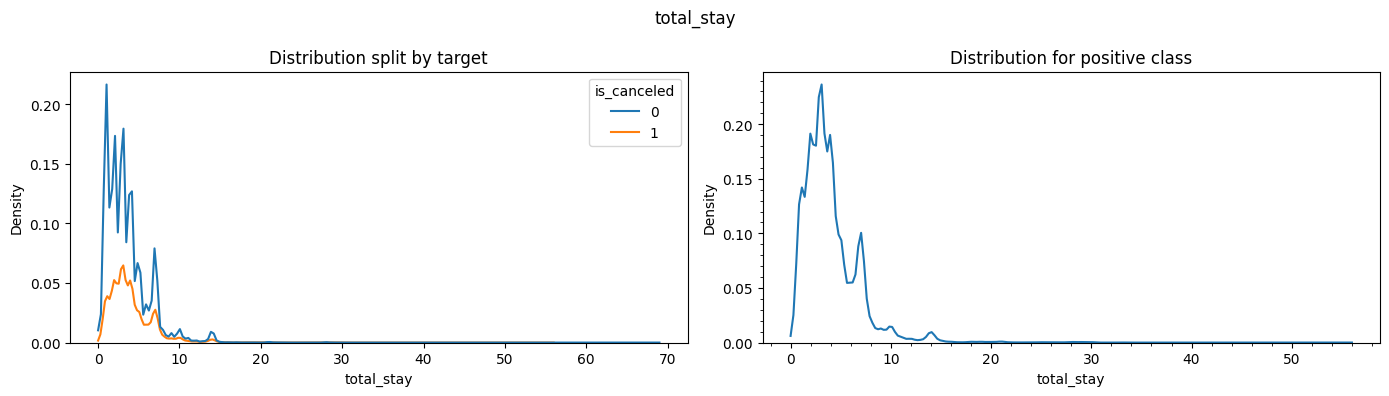

In [72]:
num_dist('total_stay')

In [73]:
data.total_stay.value_counts(normalize=True).head()

total_stay
3    0.203688
1    0.197094
2    0.179646
4    0.155199
7    0.086103
Name: proportion, dtype: float64

In [74]:
data.groupby('total_stay')[TARGET].value_counts(normalize=True)[:10]

total_stay  is_canceled
0           0              0.954899
            1              0.045101
1           0              0.818022
            1              0.181978
2           0              0.734463
            1              0.265537
3           0              0.702016
            1              0.297984
4           0              0.694647
            1              0.305353
Name: proportion, dtype: float64

**adults, children, babies**

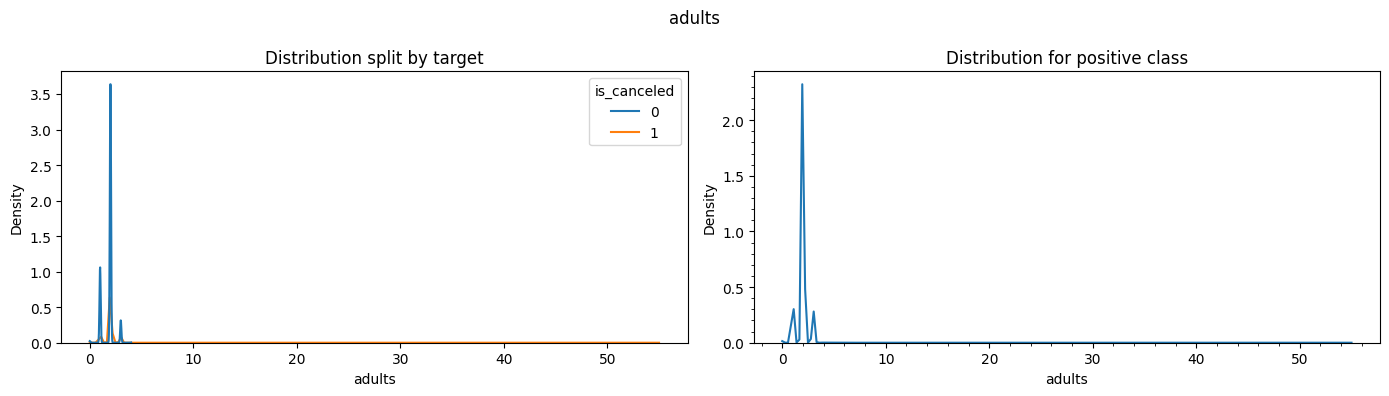

In [75]:
num_dist('adults')

In [76]:
cat_dist('adults')

Category proportions:
 adults
2     0.738878
1     0.187664
3     0.068170
0     0.004408
4     0.000694
26    0.000058
27    0.000023
20    0.000023
5     0.000023
40    0.000012
50    0.000012
55    0.000012
6     0.000012
10    0.000012
Name: proportion, dtype: float64

Target splits for each category:
 adults  is_canceled
0       0              0.748031
        1              0.251969
1       0              0.807213
        1              0.192787
2       0              0.711894
        1              0.288106
3       0              0.660217
        1              0.339783
4       0              0.766667
        1              0.233333
5       1              1.000000
6       1              1.000000
10      1              1.000000
20      1              1.000000
26      1              1.000000
27      1              1.000000
40      1              1.000000
50      1              1.000000
55      1              1.000000
Name: proportion, dtype: float64


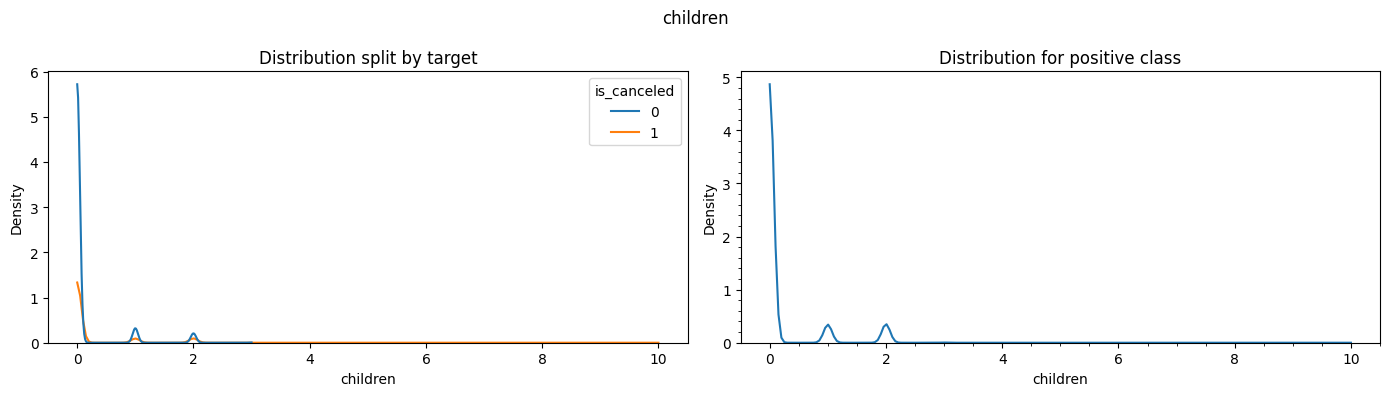

In [77]:
num_dist('children')

In [78]:
cat_dist('children')

Category proportions:
 children
0.0     0.903518
1.0     0.054101
2.0     0.041455
3.0     0.000868
NaN     0.000046
10.0    0.000012
Name: proportion, dtype: float64

Target splits for each category:
 children  is_canceled
0.0       0              0.735146
          1              0.264854
1.0       0              0.688837
          1              0.311163
2.0       0              0.582752
          1              0.417248
3.0       0              0.786667
          1              0.213333
10.0      1              1.000000
NaN       1              1.000000
Name: proportion, dtype: float64


In [79]:
data['have_children'] = (data['children'] > 0).astype('int')

In [80]:
cat_dist('have_children')

Category proportions:
 have_children
0    0.903565
1    0.096435
Name: proportion, dtype: float64

Target splits for each category:
 have_children  is_canceled
0              0              0.735108
               1              0.264892
1              0              0.644031
               1              0.355969
Name: proportion, dtype: float64


In [81]:
cat_dist('babies')

Category proportions:
 babies
0     0.989448
1     0.010355
2     0.000174
10    0.000012
9     0.000012
Name: proportion, dtype: float64

Target splits for each category:
 babies  is_canceled
0       0              0.725336
        1              0.274664
1       0              0.817877
        1              0.182123
2       0              0.866667
        1              0.133333
9       0              1.000000
10      0              1.000000
Name: proportion, dtype: float64


**previous_cancellations, previous_bookings_not_canceled**

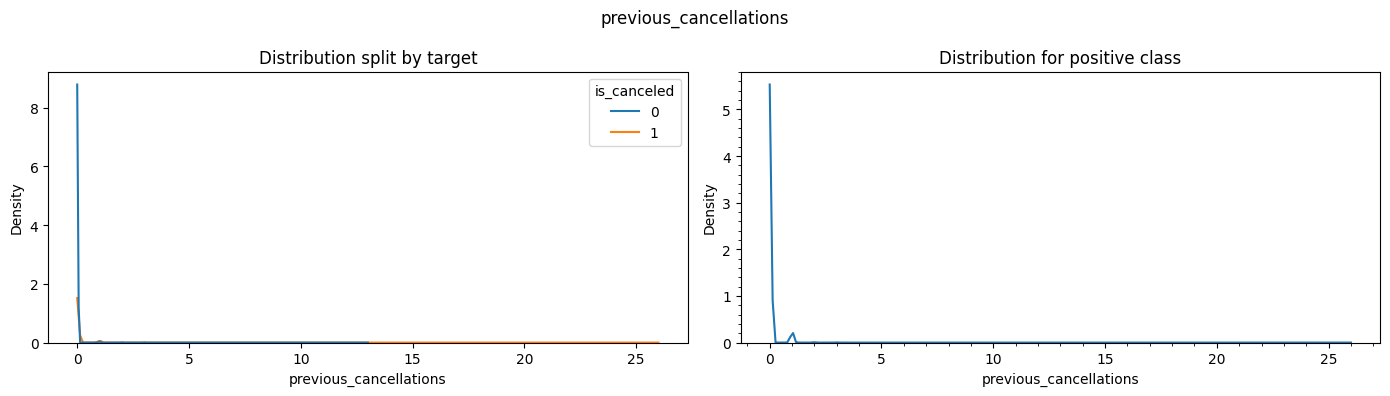

In [82]:
num_dist('previous_cancellations')

In [83]:
data['previous_cancellations'].value_counts(normalize=True).head()

previous_cancellations
0    0.980933
1    0.015862
2    0.001284
3    0.000706
4    0.000347
Name: proportion, dtype: float64

Extremely imbalanced.  
As we saw earlier, 96% of the guests are new, so they would not have any previous cancellations.  
Some repeated guests may also have no previous cancellations, making this feature even more imbalanced.

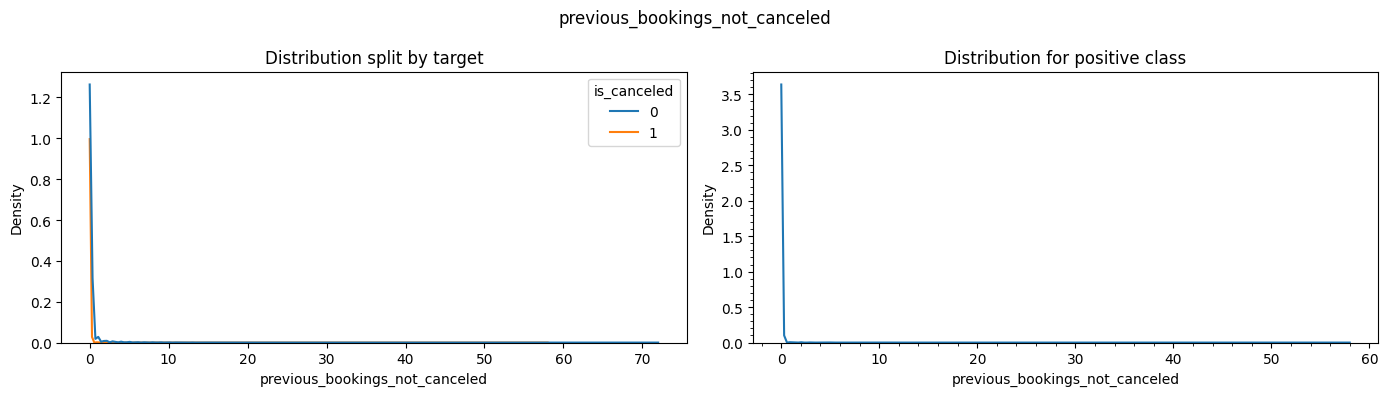

In [84]:
num_dist('previous_bookings_not_canceled')

In [85]:
data['previous_bookings_not_canceled'].value_counts(normalize=True).head()

previous_bookings_not_canceled
0    0.959042
1    0.017123
2    0.006699
3    0.003830
4    0.002638
Name: proportion, dtype: float64

Again, extremely imbalanced due to the same reason.

**days_in_waiting_list**

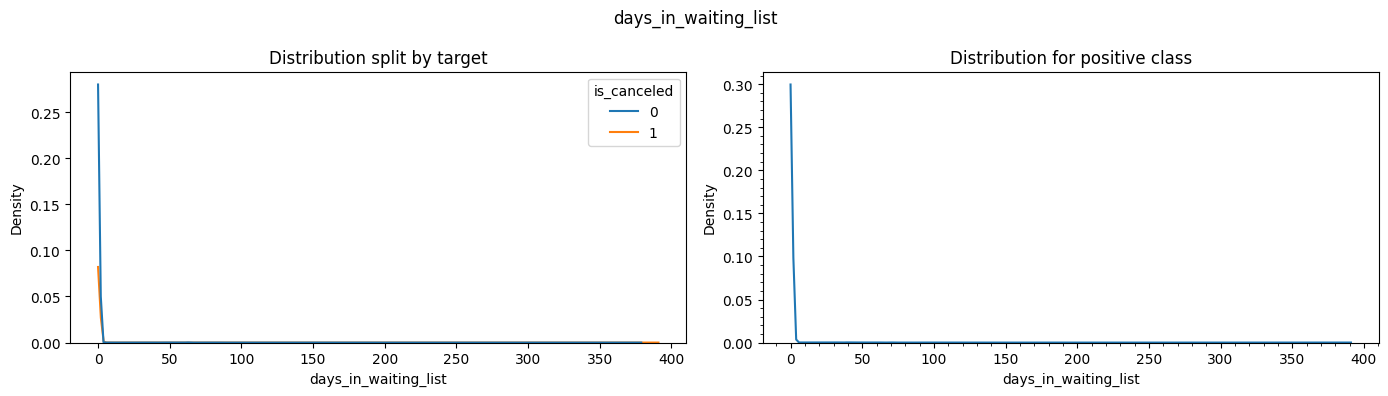

In [86]:
num_dist('days_in_waiting_list')

In [87]:
data['days_in_waiting_list'].value_counts(normalize=True).head()

days_in_waiting_list
0     0.990559
63    0.000567
15    0.000255
44    0.000255
58    0.000243
Name: proportion, dtype: float64

Low variance feature due to extreme imbalance.

**adr**

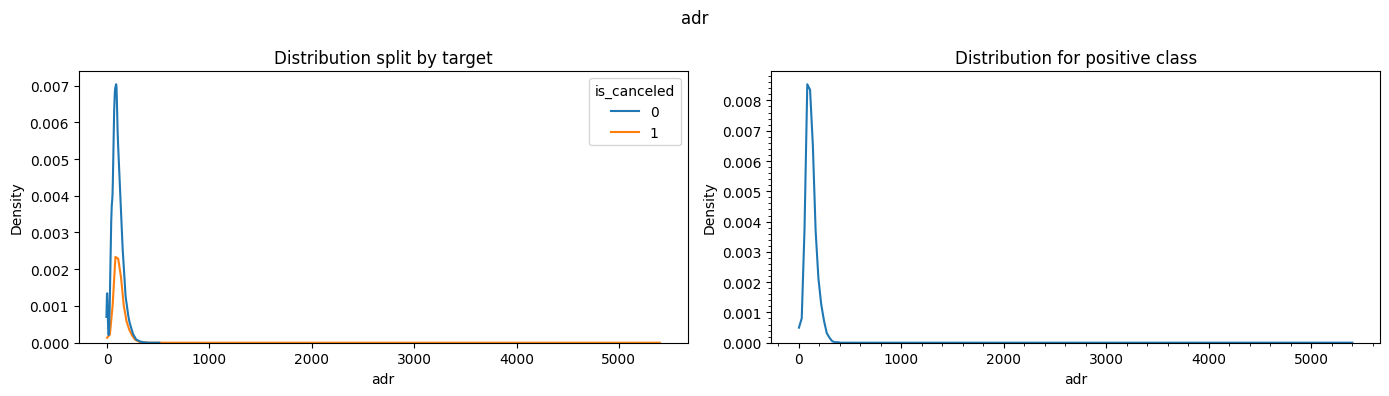

In [88]:
num_dist('adr')

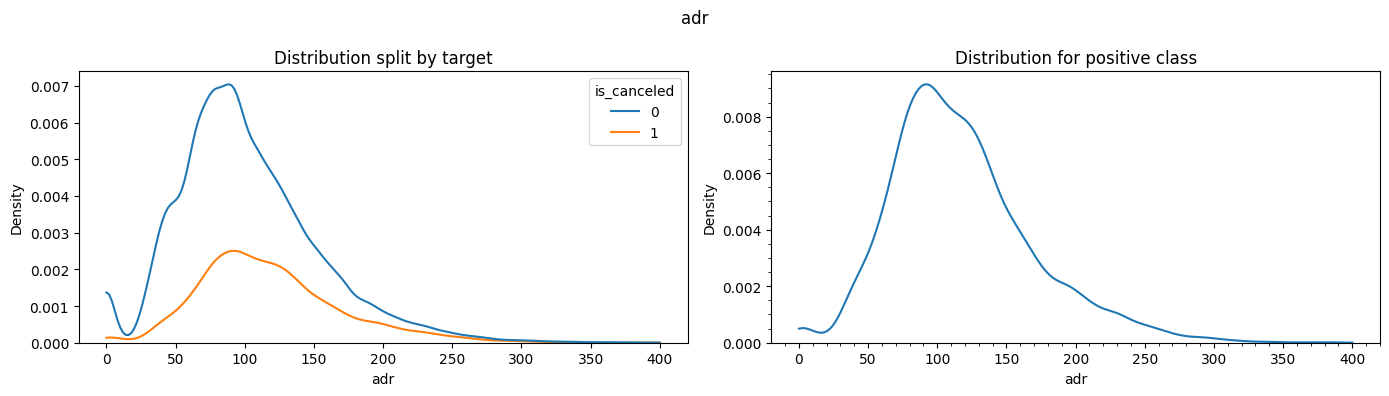

In [89]:
num_dist('adr', (0, 400))

In [90]:
data.loc[data.adr > 500]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,arrival_month_bin,meal_bin,country_bin,market_segment_bin,distribution_channel_bin,same_room_assigned,customer_type_bin,only_weekday_stay,total_stay,have_children
11497,Resort Hotel,0,1,0,July,29,15,0,1,2,0.0,0,BB,PRT,Corporate,Corporate,1,0,1,A,C,NaN,0,Transient,508.0,1,0,0,0,1,0,0,0,1,1,1,0
38278,City Hotel,1,35,1,March,13,25,0,1,2,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,12.0,0,Transient,5400.0,0,0,1,0,1,0,1,1,1,1,1,0
79809,City Hotel,0,0,2,May,19,9,0,1,1,0.0,0,BB,ITA,Offline TA/TO,TA/TO,0,0,0,A,G,159.0,0,Transient,510.0,0,0,0,0,1,0,1,0,1,1,1,0


In [91]:
data.loc[38278, 'adr'] = 540

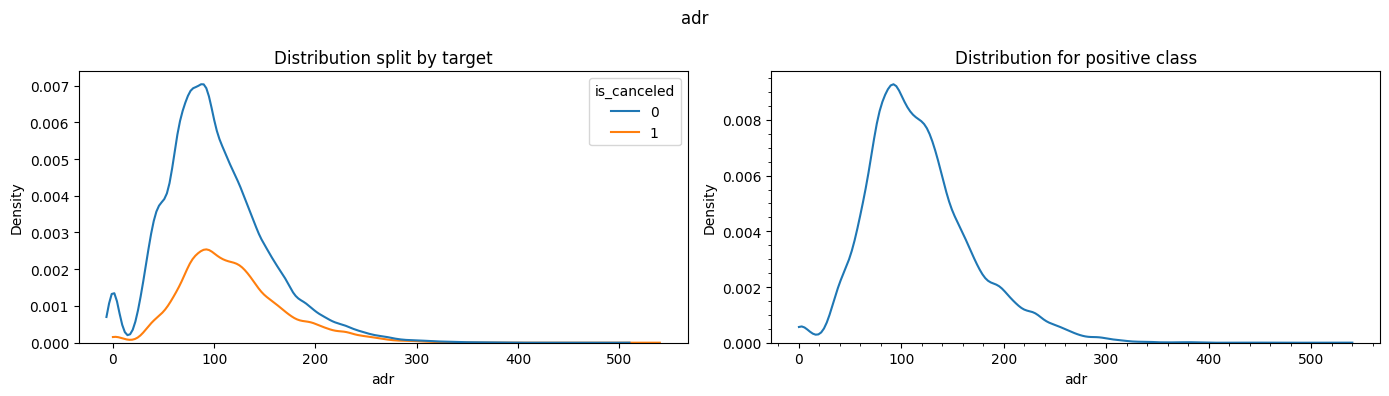

In [92]:
num_dist('adr')

**required_car_parking_spaces**

In [93]:
cat_dist('required_car_parking_spaces')

Category proportions:
 required_car_parking_spaces
0    0.915586
1    0.084032
2    0.000324
3    0.000035
8    0.000023
Name: proportion, dtype: float64

Target splits for each category:
 required_car_parking_spaces  is_canceled
0                            0              0.701093
                             1              0.298907
1                            0              1.000000
2                            0              1.000000
3                            0              1.000000
8                            0              1.000000
Name: proportion, dtype: float64


In [94]:
data['is_parking_required'] = (data['required_car_parking_spaces'] > 0).astype('int')

In [95]:
cat_dist('is_parking_required')

Category proportions:
 is_parking_required
0    0.915586
1    0.084414
Name: proportion, dtype: float64

Target splits for each category:
 is_parking_required  is_canceled
0                    0              0.701093
                     1              0.298907
1                    0              1.000000
Name: proportion, dtype: float64


Informative target splits.

**total_of_special_requests**

In [96]:
cat_dist('total_of_special_requests')

Category proportions:
 total_of_special_requests
0    0.499890
1    0.333607
2    0.135796
3    0.026634
4    0.003656
5    0.000417
Name: proportion, dtype: float64

Target splits for each category:
 total_of_special_requests  is_canceled
0                          0              0.669305
                           1              0.330695
1                          0              0.776167
                           1              0.223833
2                          0              0.788617
                           1              0.211383
3                          0              0.828410
                           1              0.171590
4                          0              0.892405
                           1              0.107595
5                          0              0.944444
                           1              0.055556
Name: proportion, dtype: float64


More special requests -> lower proportion of cancellations  
No need to binarize this feature.

# Data preparation

In [97]:
candidate_features = [
    'hotel',  # cat
    'lead_time',  # num
    'arrival_date_year',  # num
    'arrival_date_month',  # num
    'arrival_month_bin',  # cat
    'arrival_date_week_number',  # num
    'arrival_date_day_of_month',  # num
    'total_stay',  # num
    'only_weekday_stay',  # cat
    'adults',  # num
    'have_children',  # cat
    'babies',  # num
    'meal_bin',  # cat
    'country',  # cat - high cardinality
    'country_bin',  # cat
    'market_segment_bin',  # cat
    'distribution_channel_bin',  # cat
    'is_repeated_guest',  # cat
    'previous_cancellations',  # num
    'previous_bookings_not_canceled',  # num
    'same_room_assigned',  # cat
    'agent',  # cat - high cardinality
    'days_in_waiting_list',  # num
    'customer_type_bin',  # cat
    'adr',  # num
    'is_parking_required',  # cat
    'total_of_special_requests',  # num
]

In [98]:
labels = data[TARGET]
data = data[candidate_features]

### Train-Test split

In [99]:
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels,
    test_size=0.15,
    stratify=labels,  # maintain class ratio in train and test
    shuffle=True,
    random_state=SEED
)

In [100]:
train_data.shape, test_data.shape

((73466, 27), (12965, 27))

In [101]:
train_labels.value_counts(normalize=True).rename('train'), test_labels.value_counts(normalize=True).rename('test')

(is_canceled
 0    0.726322
 1    0.273678
 Name: train, dtype: float64,
 is_canceled
 0    0.72634
 1    0.27366
 Name: test, dtype: float64)

### Preprocessing

**Manually encoding low-cardinality categorical features**

In [102]:
hotel_mapping = {'Resort Hotel': 0, 'City Hotel': 1}

train_data['hotel'] = train_data.hotel.replace(hotel_mapping)
test_data['hotel'] = test_data.hotel.replace(hotel_mapping)

In [103]:
month_mapping = dict(zip(
    ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
    range(0, 12)
))

train_data['arrival_date_month'] = train_data.arrival_date_month.replace(month_mapping)
test_data['arrival_date_month'] = test_data.arrival_date_month.replace(month_mapping)

**Target-encoding high-cardinality categorical features**

In [104]:
target_encoder = TargetEncoder(target_type='binary', random_state=SEED)
train_data[['country', 'agent']] = target_encoder.fit_transform(train_data[['country', 'agent']], train_labels)
test_data[['country', 'agent']] = target_encoder.transform(test_data[['country', 'agent']])

# Feature selection

### Dropping low-variance features

In [105]:
low_var_cols = [
    'is_repeated_guest',
    'babies',
    'previous_cancellations',
    'previous_bookings_not_canceled',
    'days_in_waiting_list'
]

data = data.drop(low_var_cols, axis=1)

In [106]:
features = [f for f in candidate_features if f not in low_var_cols]

### Correlation

In [107]:
def plot_heatmap(df, size=12):
    plt.figure(figsize=(size, size * 0.75))
    sns.heatmap(
        data=df, 
        mask=np.triu(np.ones_like(df)),
        vmin=-1, vmax=1, center=0,
        annot=True, linewidths=0.1,
        fmt='.2f', annot_kws={'fontsize': 8})
    plt.show()

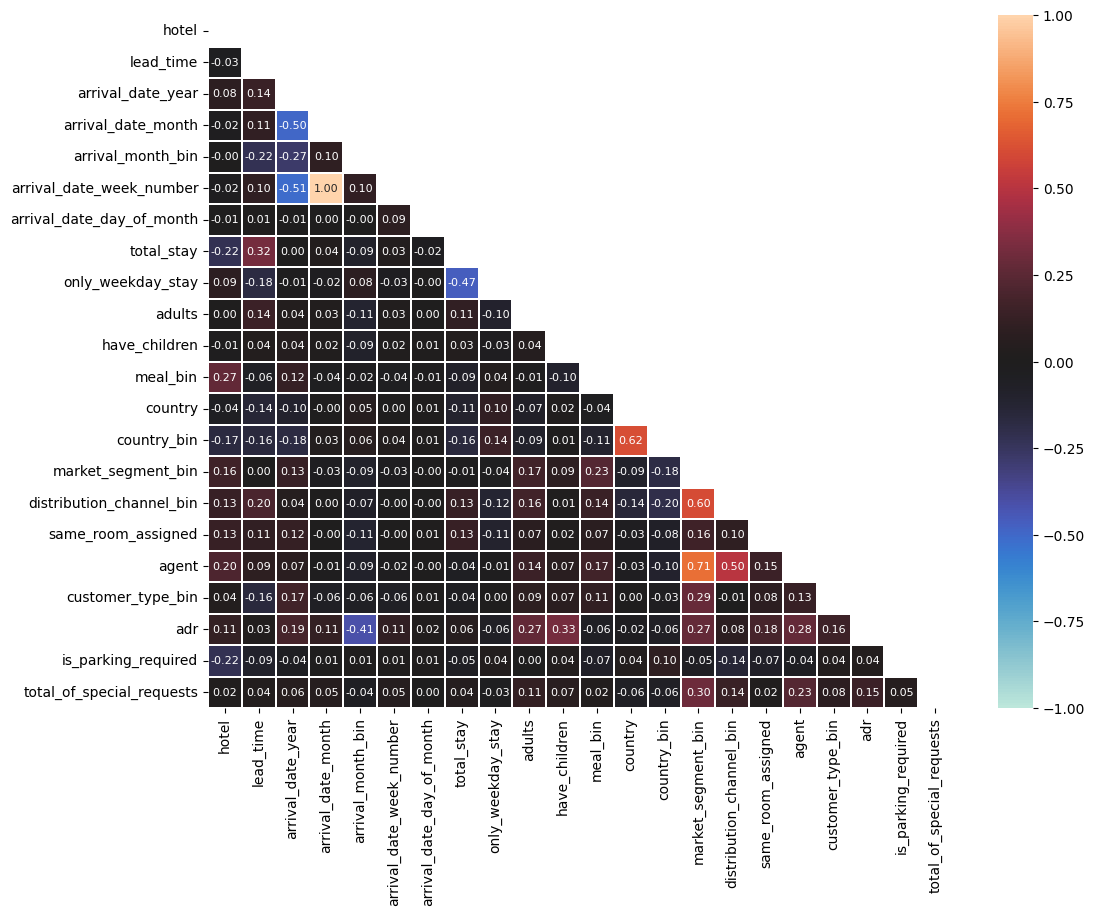

In [108]:
corr_df = train_data[features].corr(method='pearson')
plot_heatmap(corr_df)

In [109]:
def plot_bars(scores, title):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, len(scores)*0.5))
    ax.set_title(title)
    sns.barplot(x=scores.values, y=scores.index, ax=ax)
    for patch in ax.patches:
        y, height, width = patch.get_y(), patch.get_height(), patch.get_width()
        ax.text(width+0.0001, y + height/2, f'{width:.4f}', va='center', ha='left', 
                size=8, bbox={'facecolor': 'white', 'boxstyle': 'round'})

In [110]:
corr_target = train_data[features].corrwith(train_labels).sort_values(ascending=False)

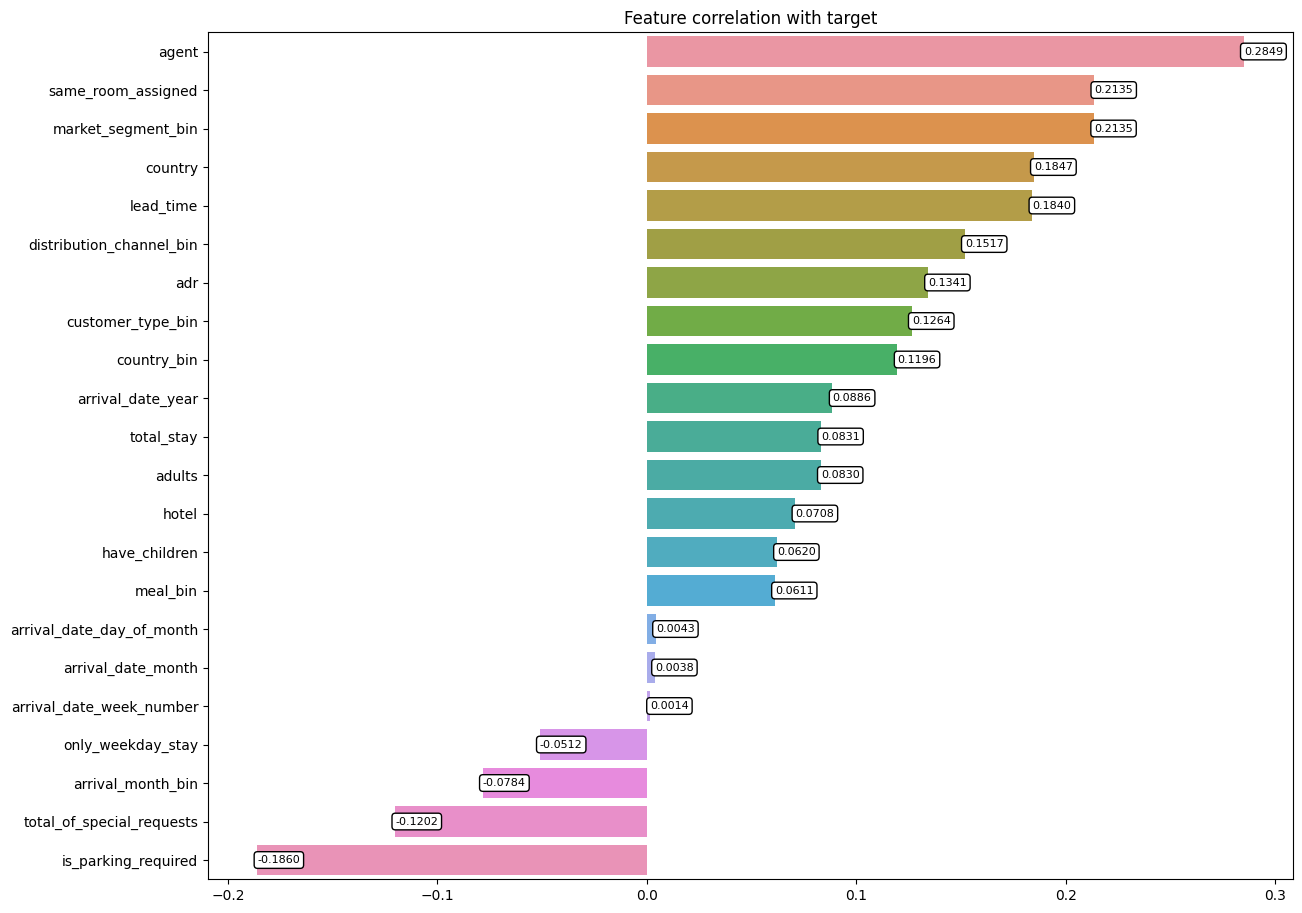

In [111]:
plot_bars(corr_target, "Feature correlation with target")

* *arrival_date_month* and *arrival_date_week_number* are perfectly correlated. One of them will be redundant.  
* Both have low correlation with target.
* We created a relatively informative binary feature from *arrival_date_month* so we can drop it.

### Mutual Information

In [112]:
cat_features = [
    'hotel', 
    'arrival_month_bin', 
    'only_weekday_stay', 
    'have_children', 
    'meal_bin', 
    'country_bin', 
    'market_segment_bin', 
    'distribution_channel_bin', 
    'same_room_assigned',
    'customer_type_bin',
    'is_parking_required'
]

num_features = [f for f in features if f not in cat_features]

In [113]:
cat_mask = [(f in cat_features) for f in features]

mi_scores = mutual_info_classif(
    train_data[features], train_labels, 
    discrete_features=cat_mask, 
    random_state=SEED
)

mi_scores = pd.Series(mi_scores, index=features).sort_values(ascending=False)

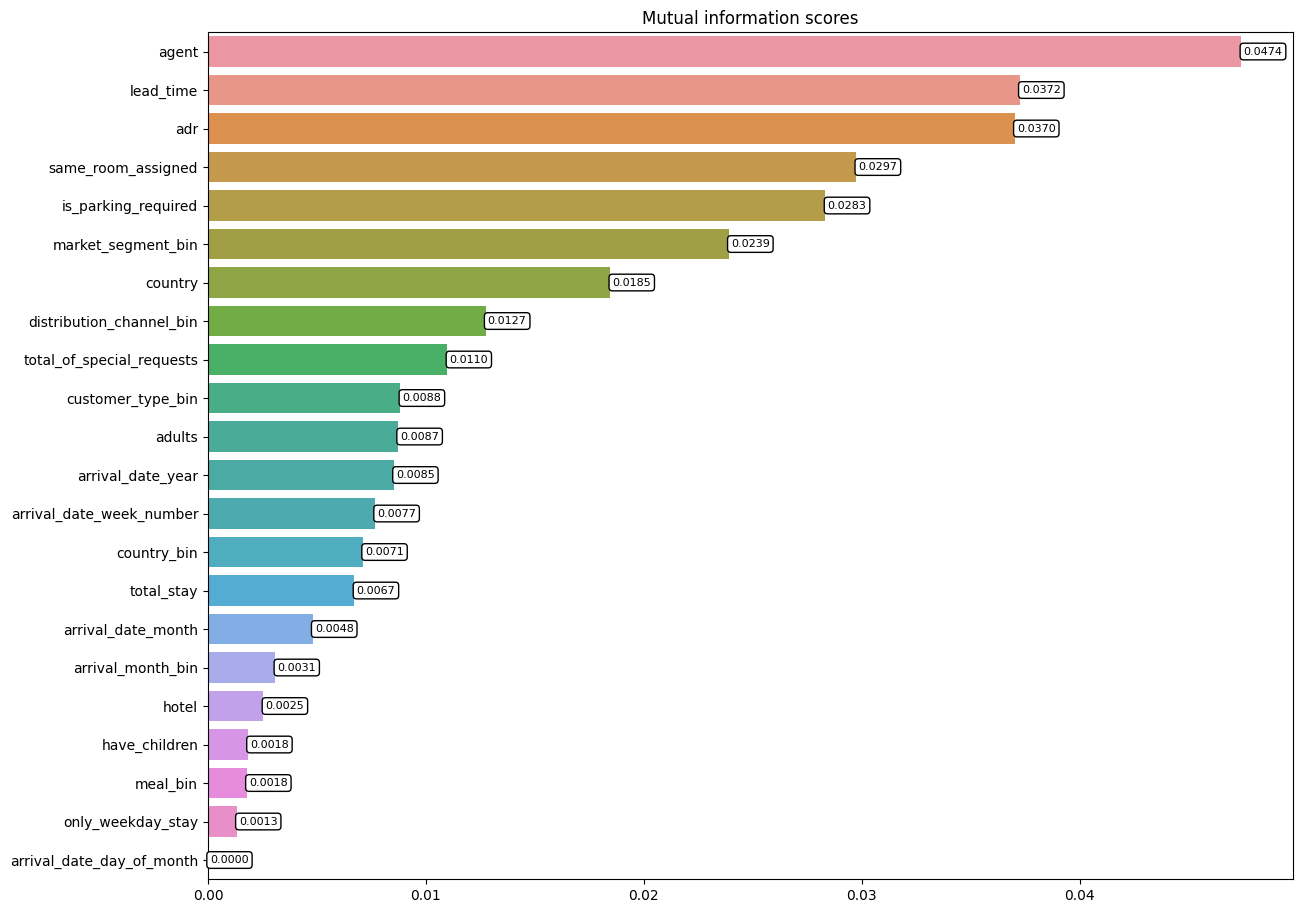

In [114]:
plot_bars(mi_scores, 'Mutual information scores')

### Chi-squared test of independence
(categorical features vs categorical target)

In [115]:
chi2_test = chi2(train_data[cat_features], train_labels)

In [116]:
pd.DataFrame(
    data={
        'chi2-statistic': chi2_test[0], 
        'p-value': chi2_test[1],
        'accepted?': chi2_test[1] < 0.05
    },
    index=cat_features
).sort_values(by='chi2-statistic')

,chi2-statistic,p-value,accepted?
only_weekday_stay,115.272958,6.857764e-27,True
hotel,143.400737,4.804105e-33,True
customer_type_bin,200.857094,1.357678e-45,True
arrival_month_bin,235.181493,4.419760e-53,True
meal_bin,244.339437,4.451938e-55,True
have_children,255.345241,1.774913e-57,True
distribution_channel_bin,353.675231,6.711472e-79,True
same_room_assigned,501.636203,4.187614e-111,True
country_bin,597.936244,4.706343e-132,True
market_segment_bin,1363.424227,1.864221e-298,True


### ANOVA F-test
(numerical features vs categorical target)

In [117]:
anova_test = f_classif(train_data[num_features], train_labels)

In [118]:
pd.DataFrame(
    data={
        'f-statistic': anova_test[0], 
        'p-value': anova_test[1],
        'accepted?': anova_test[1] < 0.05
    },
    index=num_features
).sort_values(by='f-statistic')

,f-statistic,p-value,accepted?
arrival_date_week_number,0.144335,7.040104e-01,False
arrival_date_month,1.054720,3.044259e-01,False
arrival_date_day_of_month,1.337849,2.474174e-01,False
adults,509.093564,2.411060e-112,True
total_stay,511.268033,8.172765e-113,True
arrival_date_year,581.321072,6.098885e-128,True
total_of_special_requests,1077.325964,1.408936e-234,True
adr,1345.897566,5.345781e-292,True
lead_time,2573.539560,0.000000e+00,True
country,2594.016704,0.000000e+00,True


### Model-based feature importances
(using Extremely-Randomized Trees)

In [119]:
model = ExtraTreesClassifier(n_estimators=150, max_depth=7, max_features=None, random_state=SEED)
model.fit(train_data[features], train_labels)

fimp = pd.Series(model.feature_importances_, index=model.feature_names_in_).sort_values(ascending=False)

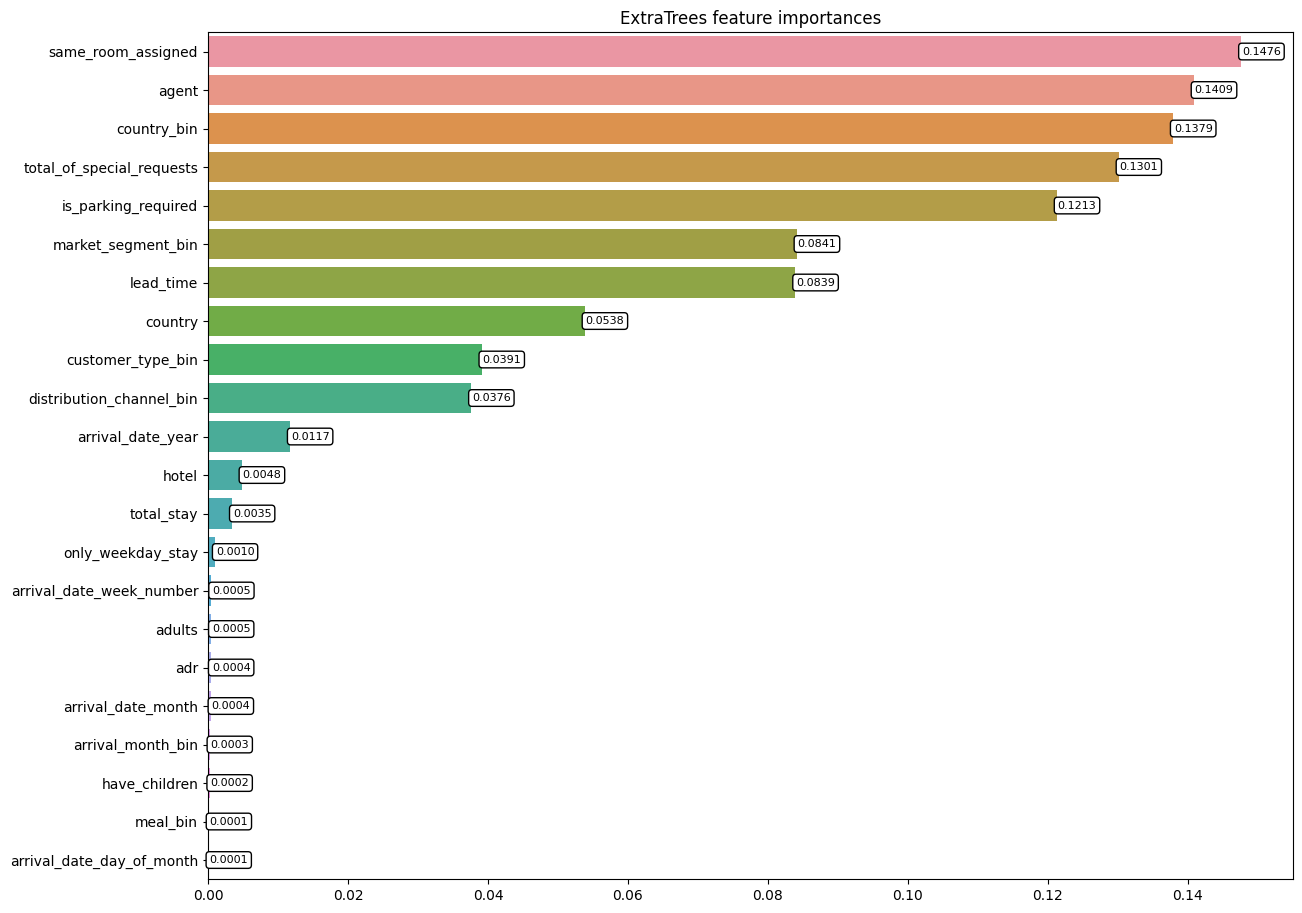

In [120]:
plot_bars(fimp, 'ExtraTrees feature importances')

### Final feature set

Based on the feature selection tests, we will drop the following features:
* arrival_date_day_of_month
* arrival_date_month
* arrival_date_week_number

In [121]:
features_to_drop = [
    'arrival_date_month', 
    'arrival_date_week_number', 
    'arrival_date_day_of_month'
]

In [122]:
features = [f for f in features if f not in features_to_drop]
num_features = [f for f in num_features if f not in features_to_drop]

In [123]:
train_data = train_data[features]
test_data = test_data[features]

# Modeling

In [124]:
def evaluate_on_test_set(model):
    global test_data, test_labels
    
    probs = model.predict_proba(test_data)[:, 1]
    auc = roc_auc_score(test_labels, probs)
    preds = model.predict(test_data)
    mcc = matthews_corrcoef(test_labels, preds)
    print(f' Area under ROC curve: {auc:.4f}')
    print(f' Matthew\'s Corr-coeff: {mcc:.4f}')
    print('\nClassification report:')
    print(classification_report(test_labels, preds, digits=4))
    
    return probs

## Logistic Regression
(using stochastic gradient-descent training)

In [126]:
lr_clf = SGDClassifier(
    loss='log_loss',
    penalty='elasticnet',
    learning_rate='constant',
    eta0=0.02,
    max_iter=2000,
    tol=2e-4,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=25,
    class_weight='balanced',
    n_jobs=-1,
    random_state=SEED
)

lr_model = make_pipeline(StandardScaler(), lr_clf)
lr_model.fit(train_data, train_labels)

lr_probs = evaluate_on_test_set(lr_model)

 Area under ROC curve: 0.8470
 Matthew's Corr-coeff: 0.4843

Classification report:
              precision    recall  f1-score   support

           0     0.9129    0.7194    0.8047      9417
           1     0.5234    0.8179    0.6384      3548

    accuracy                         0.7464     12965
   macro avg     0.7182    0.7687    0.7215     12965
weighted avg     0.8064    0.7464    0.7592     12965



## Naive-Bayes

In [128]:
gnb_model = make_pipeline(StandardScaler(), GaussianNB())
gnb_model.fit(train_data, train_labels)

gnb_probs = evaluate_on_test_set(gnb_model)

 Area under ROC curve: 0.7944
 Matthew's Corr-coeff: 0.2865

Classification report:
              precision    recall  f1-score   support

           0     0.9667    0.2931    0.4498      9417
           1     0.3415    0.9732    0.5056      3548

    accuracy                         0.4792     12965
   macro avg     0.6541    0.6332    0.4777     12965
weighted avg     0.7956    0.4792    0.4651     12965



## K-Neighbors

In [135]:
knn_clf = KNeighborsClassifier(
    n_neighbors=15, 
    weights='distance', 
    n_jobs=-1
)

knn_model = make_pipeline(StandardScaler(), knn_clf)
knn_model.fit(train_data, train_labels)

knn_probs = evaluate_on_test_set(knn_model)

 Area under ROC curve: 0.8810
 Matthew's Corr-coeff: 0.5423

Classification report:
              precision    recall  f1-score   support

           0     0.8658    0.8943    0.8799      9417
           1     0.6927    0.6322    0.6611      3548

    accuracy                         0.8226     12965
   macro avg     0.7793    0.7633    0.7705     12965
weighted avg     0.8185    0.8226    0.8200     12965



## Decision Tree

In [137]:
dt_model = DecisionTreeClassifier(
    max_depth=8, 
    class_weight='balanced',
    random_state=SEED
)
dt_model.fit(train_data, train_labels)

dt_probs = evaluate_on_test_set(dt_model)

 Area under ROC curve: 0.8820
 Matthew's Corr-coeff: 0.5443

Classification report:
              precision    recall  f1-score   support

           0     0.9460    0.7159    0.8150      9417
           1     0.5418    0.8915    0.6740      3548

    accuracy                         0.7640     12965
   macro avg     0.7439    0.8037    0.7445     12965
weighted avg     0.8354    0.7640    0.7764     12965



## Random Forest

In [138]:
rf_model = RandomForestClassifier(
    n_estimators=200, 
    max_depth=8, 
    class_weight='balanced',
    random_state=SEED,
    n_jobs=1
)
rf_model.fit(train_data, train_labels)

rf_probs = evaluate_on_test_set(rf_model)

 Area under ROC curve: 0.8958
 Matthew's Corr-coeff: 0.5614

Classification report:
              precision    recall  f1-score   support

           0     0.9450    0.7378    0.8287      9417
           1     0.5601    0.8861    0.6864      3548

    accuracy                         0.7784     12965
   macro avg     0.7526    0.8120    0.7575     12965
weighted avg     0.8397    0.7784    0.7897     12965



## AdaBoost

In [139]:
base_estimator = DecisionTreeClassifier(
    max_depth=8, 
    class_weight='balanced',
    random_state=SEED
)

adaboost_model = AdaBoostClassifier(
    estimator=base_estimator, 
    n_estimators=50, 
    learning_rate=0.05,
    algorithm='SAMME',
    random_state=SEED
)
adaboost_model.fit(train_data, train_labels)

adaboost_probs = evaluate_on_test_set(adaboost_model)

 Area under ROC curve: 0.8959
 Matthew's Corr-coeff: 0.5740

Classification report:
              precision    recall  f1-score   support

           0     0.9379    0.7670    0.8439      9417
           1     0.5832    0.8653    0.6968      3548

    accuracy                         0.7939     12965
   macro avg     0.7606    0.8161    0.7703     12965
weighted avg     0.8409    0.7939    0.8036     12965



## Multi-Layer Perceptron

In [142]:
mlp_clf = MLPClassifier(
    hidden_layer_sizes=(16, 16),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    learning_rate_init=1e-3,
    max_iter=1000,
    tol=2e-4,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=25,
    random_state=SEED
)

mlp_model = make_pipeline(StandardScaler(), mlp_clf)
mlp_model.fit(train_data, train_labels)

mlp_probs = evaluate_on_test_set(mlp_model)

 Area under ROC curve: 0.9039
 Matthew's Corr-coeff: 0.5941

Classification report:
              precision    recall  f1-score   support

           0     0.8815    0.9036    0.8924      9417
           1     0.7258    0.6776    0.7009      3548

    accuracy                         0.8417     12965
   macro avg     0.8037    0.7906    0.7966     12965
weighted avg     0.8389    0.8417    0.8400     12965



## XGBoost

In [149]:
xgb_model =  XGBClassifier(
    booster='gbtree',
    tree_method='hist',
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=class_ratio,
    learning_rate=0.1,
    n_estimators=1000,
    device='cpu',
    verbosity=0,
    seed=SEED
)
xgb_model.fit(train_data, train_labels)

xgb_probs = evaluate_on_test_set(xgb_model)

 Area under ROC curve: 0.9138
 Matthew's Corr-coeff: 0.6153

Classification report:
              precision    recall  f1-score   support

           0     0.9290    0.8275    0.8753      9417
           1     0.6451    0.8320    0.7267      3548

    accuracy                         0.8288     12965
   macro avg     0.7870    0.8298    0.8010     12965
weighted avg     0.8513    0.8288    0.8347     12965



## LightGBM

In [150]:
lgb_model = LGBMClassifier(
    boosting_type='gbdt',
    metric='auc',
    learning_rate=0.1,
    n_estimators=1000,
    is_unbalance=True,
    verbosity=-1,
    random_state=SEED
)
lgb_model.fit(train_data, train_labels)

lgb_probs = evaluate_on_test_set(lgb_model)

 Area under ROC curve: 0.9146
 Matthew's Corr-coeff: 0.6138

Classification report:
              precision    recall  f1-score   support

           0     0.9284    0.8272    0.8749      9417
           1     0.6443    0.8306    0.7257      3548

    accuracy                         0.8282     12965
   macro avg     0.7863    0.8289    0.8003     12965
weighted avg     0.8506    0.8282    0.8341     12965



## CatBoost

In [151]:
cb_model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='Logloss',
    metric_period=1,
    iterations=1000,
    learning_rate=0.1,
    auto_class_weights='SqrtBalanced',
    task_type='CPU',
    verbose=False,
    random_state=SEED
)
cb_model.fit(train_data, train_labels)

cb_probs = evaluate_on_test_set(cb_model)

 Area under ROC curve: 0.9154
 Matthew's Corr-coeff: 0.6275

Classification report:
              precision    recall  f1-score   support

           0     0.9130    0.8697    0.8908      9417
           1     0.6929    0.7802    0.7339      3548

    accuracy                         0.8452     12965
   macro avg     0.8030    0.8249    0.8124     12965
weighted avg     0.8528    0.8452    0.8479     12965



# Ensembling

In [163]:
all_probs = {
    'LogReg': lr_probs,
    'GaussNB': gnb_probs,
    'KNN': knn_probs,
    'DTree': dt_probs,
    'RForest': rf_probs,
    'AdaBoost': adaboost_probs,
    'MLP-NN': mlp_probs,
    'XGBoost': xgb_probs,
    'LGBM': lgb_probs,
    'CatBoost': cb_probs
}
probs_df = pd.DataFrame.from_dict(all_probs, orient='columns')

In [164]:
probs_df.sample(random_state=1)

,LogReg,GaussNB,KNN,DTree,RForest,AdaBoost,MLP-NN,XGBoost,LGBM,CatBoost
9724,0.103952,0.93201,0.0,0.012756,0.075981,0.119203,0.019372,0.013146,0.002413,0.01809


## Simple averaging

In [165]:
probs_simpleavg = probs_df.mean(axis=1)

In [166]:
roc_auc_score(test_labels, probs_simpleavg)

0.910824040429653

Slightly lower than the three gradient-boosting models.

## Power averaging
(squared)

In [168]:
probs_squaredavg = probs_df.apply(lambda x: x**2).mean(axis=1)

In [169]:
roc_auc_score(test_labels, probs_squaredavg)

0.9061727399618743

Worse than simple averaging. 

## Weighted averaging

Lower weights assigned to models with worse performance

In [173]:
probs_weightedavg = probs_df['LogReg'] * 0.05 \
                  + probs_df['GaussNB'] * 0.0 \
                  + probs_df['KNN'] * 0.1 \
                  + probs_df['DTree'] * 0.05 \
                  + probs_df['RForest'] * 0.1 \
                  + probs_df['AdaBoost'] * 0.1 \
                  + probs_df['MLP-NN'] * 0.1 \
                  + probs_df['XGBoost'] * 0.15 \
                  + probs_df['LGBM'] * 0.15 \
                  + probs_df['CatBoost'] * 0.20

In [174]:
roc_auc_score(test_labels, probs_weightedavg)

0.9159584976629016

* Best AUC out of all models.
* Further tuning can be done for assigned weights.